In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, udf, when, length
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from textblob import TextBlob


In [3]:
spark = SparkSession.builder.appName('FakeNewsDetection').getOrCreate()


In [4]:
data = spark.read.csv('/content/FA-KES-Dataset.csv', header=True, inferSchema=True, encoding='latin1')
data.show(5)
data.printSchema()

+----------+--------------------+--------------------+------+---------+--------+------+
|   unit_id|       article_title|     article_content|source|     date|location|labels|
+----------+--------------------+--------------------+------+---------+--------+------+
|1914947530|Syria attack symp...|"Wed 05 Apr 2017 ...|   nna| 4/5/2017|   idlib|     0|
|1914947532|Homs governor say...|"Fri 07 Apr 2017 ...|   nna| 4/7/2017|    homs|     0|
|1914947533|Death toll from A...|Sun 16 Apr 2017 D...|   nna|4/16/2017|  aleppo|     0|
|1914947534|Aleppo bomb blast...|Wed 19 Apr 2017 A...|   nna|4/19/2017|  aleppo|     0|
|1914947535|29 Syria Rebels D...|Sun 10 Jul 2016 2...|   nna|7/10/2016|  aleppo|     0|
+----------+--------------------+--------------------+------+---------+--------+------+
only showing top 5 rows

root
 |-- unit_id: integer (nullable = true)
 |-- article_title: string (nullable = true)
 |-- article_content: string (nullable = true)
 |-- source: string (nullable = true)
 |-- dat

In [5]:
print(data.columns)

['unit_id', 'article_title', 'article_content', 'source', 'date', 'location', 'labels']


In [6]:
data = data.na.drop(subset=["article_content", "article_title", "labels"])
data = data.fillna({"source": "Unknown", "location": "Unknown"})
data.show(truncate=False)

+----------+----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
from pyspark.sql.functions import regexp_replace, lower

# Remove punctuation and convert to lowercase
data = data.withColumn("Cleaned_Title", lower(regexp_replace(col("article_title"), "[^a-zA-Z\s]", "")))
data = data.withColumn("Cleaned_Content", lower(regexp_replace(col("article_content"), "[^a-zA-Z\s]", "")))


In [8]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Tokenize
tokenizer = Tokenizer(inputCol="Cleaned_Content", outputCol="Words")
data = tokenizer.transform(data)

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="Words", outputCol="Filtered_Words")
data = stopwords_remover.transform(data)


In [9]:
from pyspark.ml.feature import CountVectorizer, IDF

# Count Vectorizer
cv = CountVectorizer(inputCol="Filtered_Words", outputCol="Raw_Features")
cv_model = cv.fit(data)
data = cv_model.transform(data)

# TF-IDF
idf = IDF(inputCol="Raw_Features", outputCol="TFIDF_Features")
idf_model = idf.fit(data)
data = idf_model.transform(data)


In [11]:
from pyspark.sql.functions import length, udf
from textblob import TextBlob
from pyspark.sql.types import DoubleType

# Word and character count
data = data.withColumn("Word_Count", length(col("Cleaned_Content")))
data = data.withColumn("Char_Count", length(col("article_content")))
data.show(truncate=False)
# Title sentiment score
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_udf = udf(sentiment_analysis, DoubleType())
data = data.withColumn("Title_Sentiment", sentiment_udf(col("Cleaned_Title")))
data.show(truncate=False)

+----------+----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

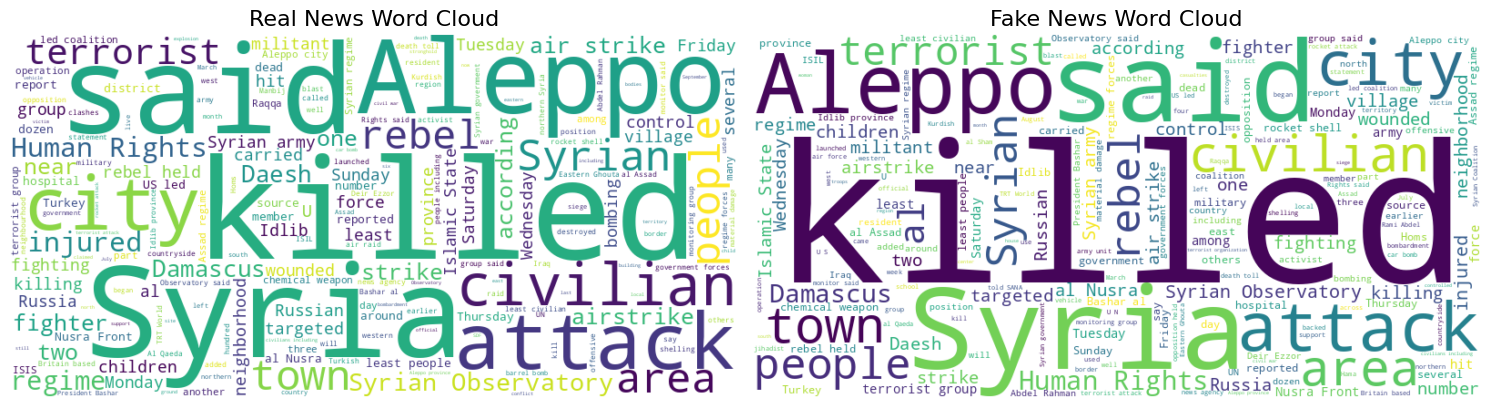

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the dataset for real and fake news
real_news = data.filter(data["labels"] == 1).select("article_content").rdd.flatMap(lambda x: x).collect()
fake_news = data.filter(data["labels"] == 0).select("article_content").rdd.flatMap(lambda x: x).collect()

# Create the text for word clouds
real_text = " ".join(real_news)
fake_text = " ".join(fake_news)

# Generate word clouds
real_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(real_text)
fake_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(fake_text)

# Plot them side by side
plt.figure(figsize=(15, 7))

# Real News Word Cloud
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(real_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Real News Word Cloud", fontsize=16)

# Fake News Word Cloud
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(fake_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Fake News Word Cloud", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


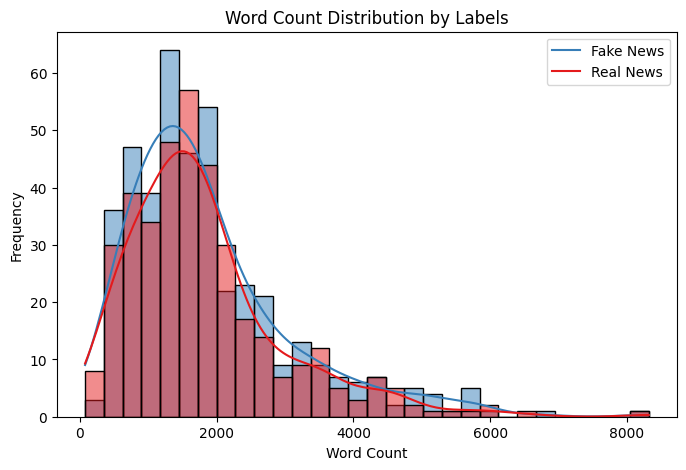

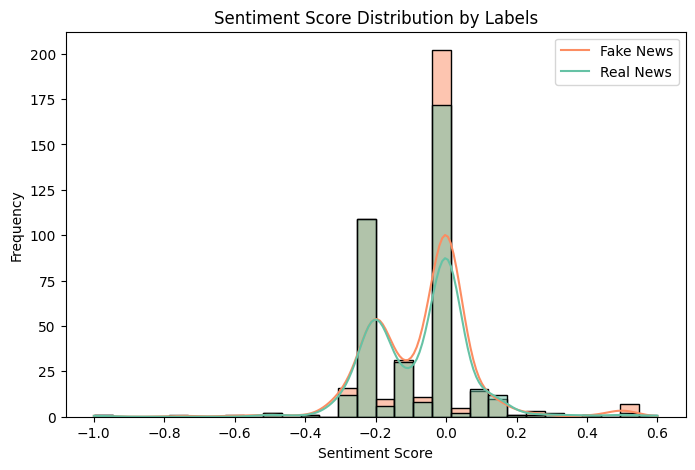

In [14]:
# Convert the Spark DataFrame to Pandas for visualization
pandas_df = data.select("Word_Count", "Title_Sentiment", "labels").toPandas()

import seaborn as sns

# Word Count Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=pandas_df, x="Word_Count", hue="labels", bins=30, kde=True, palette="Set1")
plt.title("Word Count Distribution by Labels")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(["Fake News", "Real News"])
plt.show()

# Sentiment Score Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=pandas_df, x="Title_Sentiment", hue="labels", bins=30, kde=True, palette="Set2")
plt.title("Sentiment Score Distribution by Labels")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend(["Fake News", "Real News"])
plt.show()


+------+-----+
|labels|count|
+------+-----+
|     1|  426|
|     0|  378|
+------+-----+



<ipython-input-15-979ae0e119d1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="labels", y="count", data=class_counts, palette="pastel")


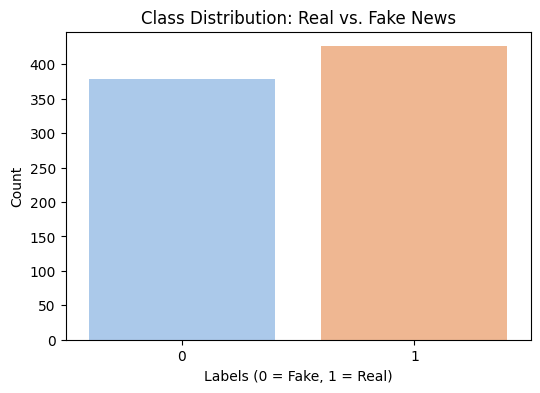

In [15]:
# Count the number of samples for each class
class_distribution = data.groupBy("labels").count()
class_distribution.show()

# Visualize class distribution
class_counts = class_distribution.toPandas()
plt.figure(figsize=(6, 4))
sns.barplot(x="labels", y="count", data=class_counts, palette="pastel")
plt.title("Class Distribution: Real vs. Fake News")
plt.xlabel("Labels (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.show()


Before SMOTE Class Distribution: Counter({1: 426, 0: 378})
After SMOTE Class Distribution: Counter({0: 426, 1: 426})

Original Dataset Shape: (804, 3) 804
Resampled Dataset Shape: (852, 3) 852

Preview of Resampled Dataset:
   Word_Count  Char_Count  Title_Sentiment  labels
0    0.327785    0.316123         2.153326       0
1    0.166850    0.189931         0.464714       0
2   -0.376307   -0.377114        -1.561621       0
3   -1.222893   -1.225222         0.464714       0
4   -1.151645   -1.153113        -0.210731       0


<ipython-input-16-c9107c4ce8dc>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="labels", data=resampled_df, palette="pastel")


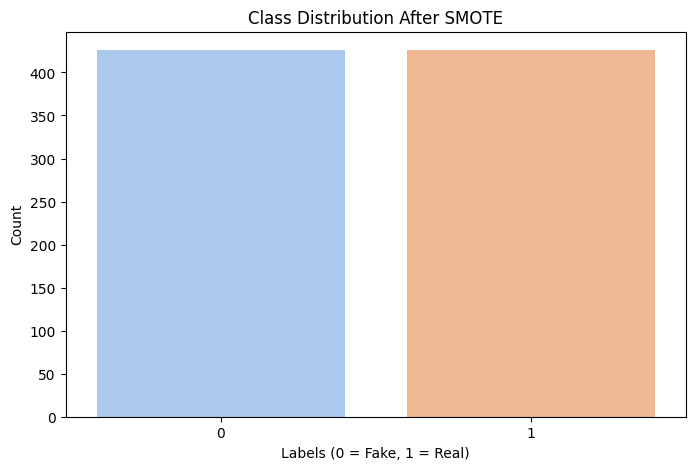

In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

X = data.select("Word_Count", "Char_Count", "Title_Sentiment").toPandas()
y = data.select("labels").toPandas().squeeze()

print("Before SMOTE Class Distribution:", Counter(y))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("After SMOTE Class Distribution:", Counter(y_resampled))

print("\nOriginal Dataset Shape:", X_scaled.shape, len(y))
print("Resampled Dataset Shape:", X_resampled.shape, len(y_resampled))

resampled_df = pd.DataFrame(X_resampled, columns=["Word_Count", "Char_Count", "Title_Sentiment"])
resampled_df["labels"] = y_resampled
print("\nPreview of Resampled Dataset:")
print(resampled_df.head())

plt.figure(figsize=(8, 5))
sns.countplot(x="labels", data=resampled_df, palette="pastel")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Labels (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.show()



Logistic Regression:
Accuracy: 0.3918
              precision    recall  f1-score   support

           0       0.37      0.66      0.47        71
           1       0.45      0.20      0.28       100

    accuracy                           0.39       171
   macro avg       0.41      0.43      0.38       171
weighted avg       0.42      0.39      0.36       171


Naive Bayes Classifier (GaussianNB):
Accuracy: 0.3977
              precision    recall  f1-score   support

           0       0.38      0.69      0.49        71
           1       0.46      0.19      0.27       100

    accuracy                           0.40       171
   macro avg       0.42      0.44      0.38       171
weighted avg       0.43      0.40      0.36       171


Random Forest Classifier:
Accuracy: 0.5439
              precision    recall  f1-score   support

           0       0.46      0.51      0.48        71
           1       0.62      0.57      0.59       100

    accuracy                           0.54 

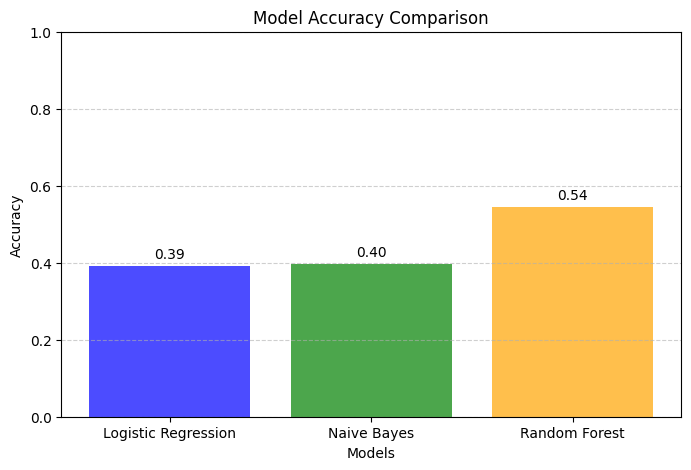

In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(random_state=42, max_iter=500)
nb_model = GaussianNB()
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print("\nLogistic Regression:")
print(f"Accuracy: {logistic_accuracy:.4f}")
print(classification_report(y_test, logistic_predictions))

nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("\nNaive Bayes Classifier (GaussianNB):")
print(f"Accuracy: {nb_accuracy:.4f}")
print(classification_report(y_test, nb_predictions))

rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("\nRandom Forest Classifier:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_predictions))

model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest']
accuracies = [logistic_accuracy, nb_accuracy, rf_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'], alpha=0.7)
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=10, color='black')
plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Gaussian Naive Bayes Parameters: {}
Best Gaussian Naive Bayes CV Score: 0.536077715757836

Tuned Gaussian Naive Bayes Accuracy: 0.39766081871345027
              precision    recall  f1-score   support

           0       0.38      0.69      0.49        71
           1       0.46      0.19      0.27       100

    accuracy                           0.40       171
   macro avg       0.42      0.44      0.38       171
weighted avg       0.43      0.40      0.36       171

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest CV Score: 0.5050665521683125

Tuned Random Forest Accuracy: 0.5497076023391813
              precision    recall  f1-score   support

           0       0.46      0.49      0.48        71
           1       0.62      0.59      0.61       100

    accuracy    

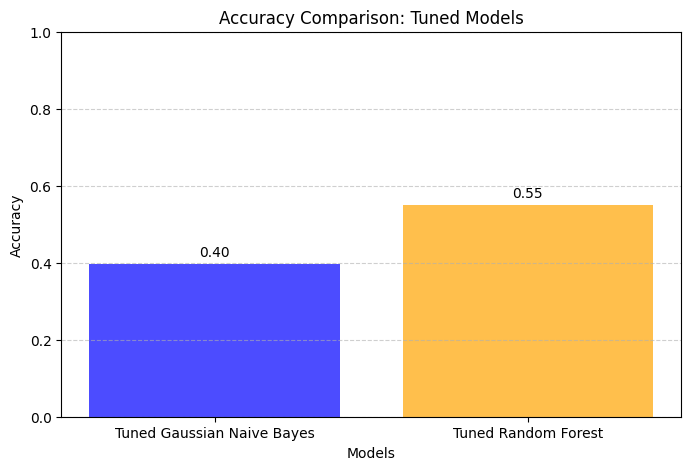

In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

scaler = MaxAbsScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gnb_param_grid = {}

gnb_grid_search = GridSearchCV(GaussianNB(), gnb_param_grid, cv=5, scoring='accuracy', verbose=1)
gnb_grid_search.fit(X_train_scaled, y_train)
best_gnb_model = gnb_grid_search.best_estimator_
gnb_tuned_predictions = best_gnb_model.predict(X_test_scaled)
gnb_tuned_accuracy = accuracy_score(y_test, gnb_tuned_predictions)

print("\nBest Gaussian Naive Bayes Parameters:", gnb_grid_search.best_params_)
print("Best Gaussian Naive Bayes CV Score:", gnb_grid_search.best_score_)
print("\nTuned Gaussian Naive Bayes Accuracy:", gnb_tuned_accuracy)
print(classification_report(y_test, gnb_tuned_predictions))

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', verbose=1)
rf_grid_search.fit(X_train_scaled, y_train)
best_rf_model = rf_grid_search.best_estimator_
rf_tuned_predictions = best_rf_model.predict(X_test_scaled)
rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_predictions)

print("\nBest Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest CV Score:", rf_grid_search.best_score_)
print("\nTuned Random Forest Accuracy:", rf_tuned_accuracy)
print(classification_report(y_test, rf_tuned_predictions))

model_names = ['Tuned Gaussian Naive Bayes', 'Tuned Random Forest']
accuracies = [gnb_tuned_accuracy, rf_tuned_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'orange'], alpha=0.7)
plt.ylim(0, 1)
plt.title("Accuracy Comparison: Tuned Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=10, color='black')
plt.show()


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

nb_predictions = nb_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions)
nb_recall = recall_score(y_test, nb_predictions)
nb_f1 = f1_score(y_test, nb_predictions)
nb_roc_auc = roc_auc_score(y_test, nb_predictions)

rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)

print("Naive Bayes Performance Metrics:")
print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1-Score: {nb_f1}")
print(f"ROC-AUC Score: {nb_roc_auc}")
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))

print("\nRandom Forest Performance Metrics:")
print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1-Score: {rf_f1}")
print(f"ROC-AUC Score: {rf_roc_auc}")
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_predictions))


Naive Bayes Performance Metrics:
Accuracy: 0.39766081871345027
Precision: 0.4634146341463415
Recall: 0.19
F1-Score: 0.2695035460992908
ROC-AUC Score: 0.4400704225352112

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.69      0.49        71
           1       0.46      0.19      0.27       100

    accuracy                           0.40       171
   macro avg       0.42      0.44      0.38       171
weighted avg       0.43      0.40      0.36       171


Random Forest Performance Metrics:
Accuracy: 0.543859649122807
Precision: 0.6195652173913043
Recall: 0.57
F1-Score: 0.59375
ROC-AUC Score: 0.5385211267605633

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.51      0.48        71
           1       0.62      0.57      0.59       100

    accuracy                           0.54       171
   macro avg       0.54      0.54      0.54       1

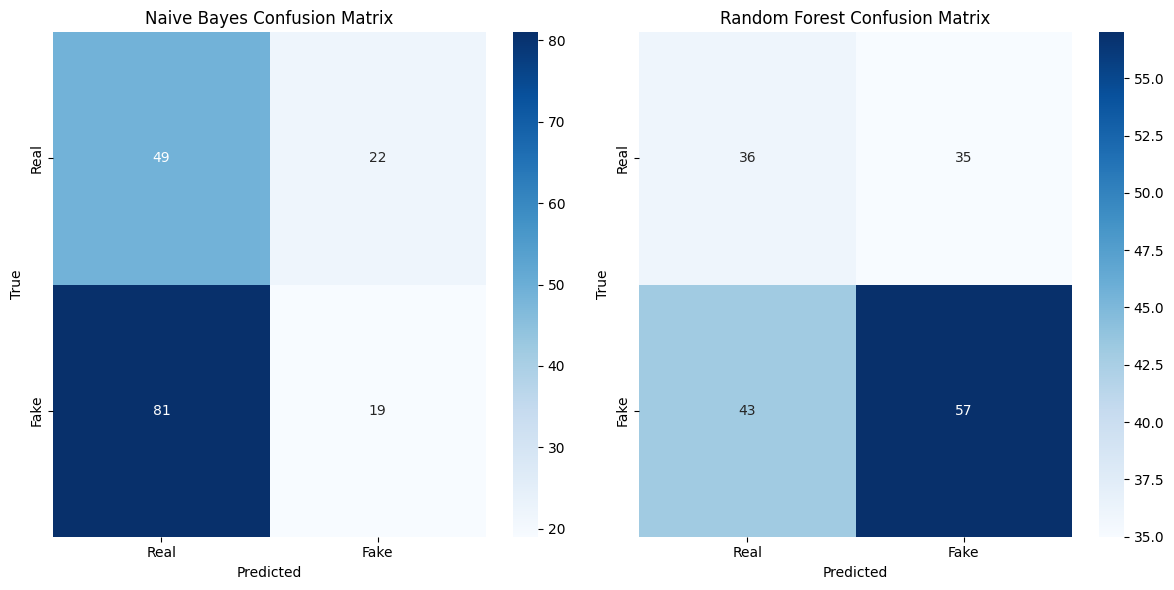

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix_nb = confusion_matrix(y_test, nb_predictions)
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"], ax=axes[0])
axes[0].set_title("Naive Bayes Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"], ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()

plt.show()


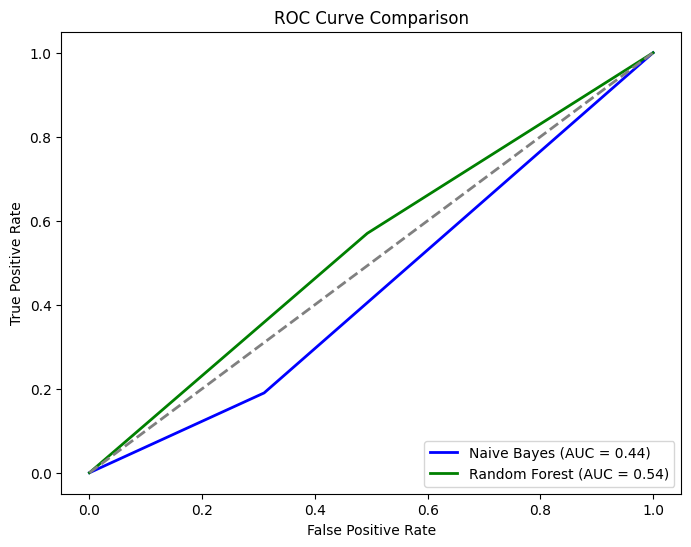

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_predictions)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predictions)

roc_auc_nb = auc(fpr_nb, tpr_nb)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()



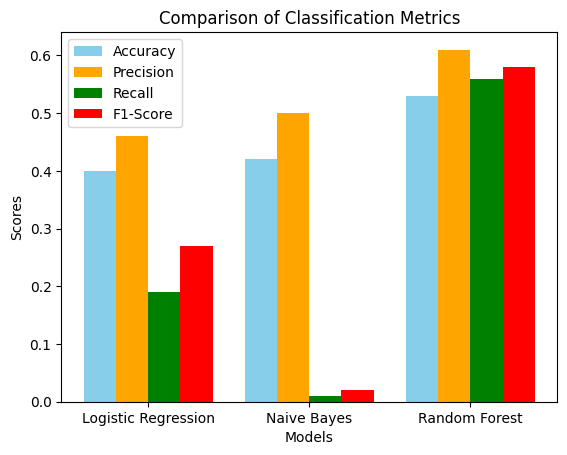

In [22]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Logistic Regression', 'Naive Bayes', 'Random Forest']
accuracy = [0.40, 0.42, 0.53]
precision = [0.46, 0.50, 0.61]
recall = [0.19, 0.01, 0.56]
f1_score = [0.27, 0.02, 0.58]

x = np.arange(len(models))
width = 0.2

plt.bar(x - 0.3, accuracy, width, label='Accuracy', color='skyblue')
plt.bar(x - 0.1, precision, width, label='Precision', color='orange')
plt.bar(x + 0.1, recall, width, label='Recall', color='green')
plt.bar(x + 0.3, f1_score, width, label='F1-Score', color='red')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Classification Metrics')
plt.xticks(x, models)
plt.legend()
plt.show()
